### Reimplementation of Image Super-Resolution Using Deep Convolutional Network in PyTorch

This notebook is the reimplementation of this [paper](https://arxiv.org/abs/1501.00092)

In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import numpy as np
import time
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.input = self.file['data']
        self.target = self.file['label']
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self,idx):
        input = torch.tensor(self.input[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        
        return input, target
    
    def close(self):
        self.file.close()       

Image input size:  torch.Size([3, 33, 33])


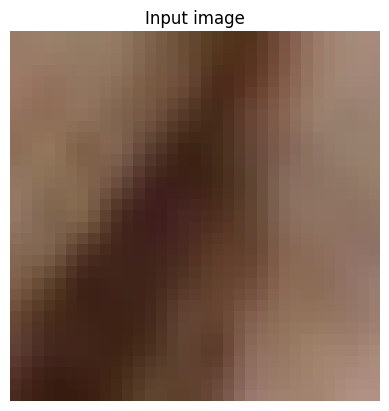

Image target size:  torch.Size([3, 21, 21])


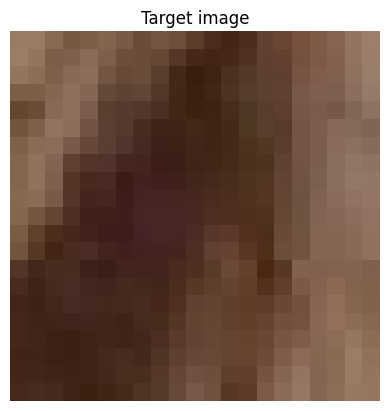

In [3]:
# Create an instance of MyDataset
dataset = MyDataset('train.h5')
test_dataset = MyDataset('test.h5')

# Choose the index of the data point you want to print
index_to_print = 4

# Retrieve the specified data point from the dataset
input, target = dataset[index_to_print]
image_test, label_test = test_dataset[index_to_print]


print("Image input size: ", input.size())


# Convert the image tensor to a PIL image for visualization
pil_input = to_pil_image(input)
pil_target = to_pil_image(target)

# Display the image using Matplotlib
plt.imshow(pil_input)
plt.title("Input image")
plt.axis('off')
plt.show()

print("Image target size: ", target.size())
# Print information about the label
plt.title("Target image")
plt.imshow(pil_target)
plt.axis('off')
plt.show()


# Close the dataset (important for releasing resources)
dataset.close()

### Preparing Datasets and Dataloaders

The train.h5 and test.h5 files are obtained by running the MATLAB scripts generate_train and generate_test respectively from [this](https://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip) source code given in the original paper

In [4]:
# Define dataset and dataloader
dataset = MyDataset('train.h5') 
train_loader = DataLoader(dataset, batch_size=128)

dataset_test_set5 = MyDataset('test.h5')
val_loader = DataLoader(dataset_test_set5, batch_size=128)

### Defining the CNN model

In [5]:
# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Feature extraction layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),  # Input channels: 3 (RGB)
            nn.ReLU(True)
        )
        # Non-linear mapping layer
        self.map = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )
        # Reconstruction layer
        self.reconstruction = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        self.upsample = nn.Upsample(scale_factor=1.5715, mode='bicubic')  # Upsample to match target size (33x33)

        
    def forward(self, x):
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        out = self.upsample(out)
        return out
    
    def _initialize_weights(self):
        # Initialize weights with Gaussian distribution (std=0.001) and bias with zeros
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize convolutional layer weights with Gaussian distribution (std=0.001)
                nn.init.normal_(m.weight, mean=0, std=0.001)
                if m.bias is not None:
                    # Initialize bias with zeros
                    nn.init.constant_(m.bias, 0)

model = SRCNN()

In [8]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),  # Input channels: 3 (RGB)
            nn.ReLU(True)
        )
        self.map = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )
        self.reconstruction = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Initialize model, loss function, and optimizer
model = SRCNN()
criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
num_epochs = 20

### Training loop

In [9]:
import torch.nn.functional as F
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        """ if batch_idx==0:
            print("Input size: ",inputs.size())
            print("Target size: ", targets.size()) """
        # Forward pass
        #targets_resized = F.interpolate(targets, size=(33, 33), mode='bicubic', align_corners=False)
        
        outputs = model(inputs)
        
        if outputs.size() != targets.size():
            outputs = F.interpolate(outputs, size=targets.size()[2:], mode='bicubic', align_corners=False)
        
        """ if batch_idx==0:
            print("Inputs size: ", inputs.size())
            print("Output size: ", outputs.size())
            print("targets size: ", targets.size()) """
        #outputs_resized = torch.nn.functional.interpolate(outputs, size=(21,21), mode='bilinear', align_corners=False)

        #print("Output dimension ", outputs_resized[0].size())
        # Print shapes of outputs and targets
        #inputs_resized = F.interpolate(inputs, size=(21, 21), mode='bicubic', align_corners=False)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

end_time = time.time()
training_time_baseline = end_time - start_time
print(f"Training completed in {training_time_baseline:.2f} seconds")
# Save the trained model
torch.save(model.state_dict(), 'srcnn_model.pth')

Epoch 1, Loss: 0.03534089898800149
Epoch 2, Loss: 0.016787211498355166
Epoch 3, Loss: 0.013883247483959969
Epoch 4, Loss: 0.01243765036958982
Epoch 5, Loss: 0.011405873161685818
Epoch 6, Loss: 0.010635213247116875
Epoch 7, Loss: 0.010018392148263314
Epoch 8, Loss: 0.009497528550598551
Epoch 9, Loss: 0.009057501059792498
Epoch 10, Loss: 0.008691432201029622
Epoch 11, Loss: 0.008390409932197893
Epoch 12, Loss: 0.008145768617225043
Epoch 13, Loss: 0.007949355496641467
Epoch 14, Loss: 0.0077927274328163446
Epoch 15, Loss: 0.007667933889281224
Epoch 16, Loss: 0.0075680341105908155
Epoch 17, Loss: 0.007486989179297405
Epoch 18, Loss: 0.007419722171171623
Epoch 19, Loss: 0.007362174434477792
Epoch 20, Loss: 0.0073112340890528526
Training completed in 800.81 seconds


Validation Loss: 0.005594004353042692


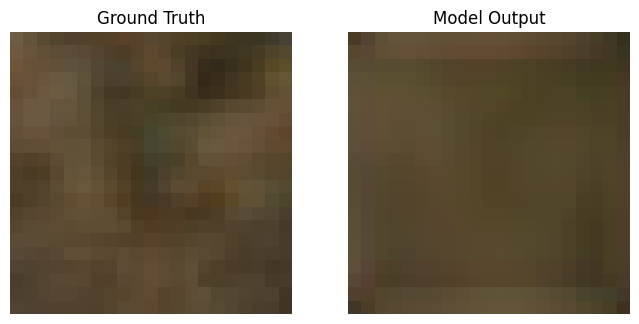

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()

# Evaluate model on validation dataset
model.eval()
val_loss = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(val_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        # Ensure the output and target sizes match
        if val_outputs.size() != val_labels.size():
            val_outputs = F.interpolate(val_outputs, size=val_labels.size()[2:], mode='bicubic', align_corners=False)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {average_val_loss}")

    # Visualize some example results
    index_to_print = 69
    val_inputs, val_labels = next(iter(val_loader))
    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
    val_outputs = model(val_inputs)
    
    if val_outputs.size() != val_labels.size():
        val_outputs = F.interpolate(val_outputs, size=val_labels.size()[2:], mode='bicubic', align_corners=False)
    
    val_outputs = val_outputs.cpu()
    val_labels = val_labels.cpu()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(to_pil_image(val_labels[index_to_print]))
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(val_outputs[index_to_print]))
    plt.title('Model Output')
    plt.axis('off')

    plt.show()


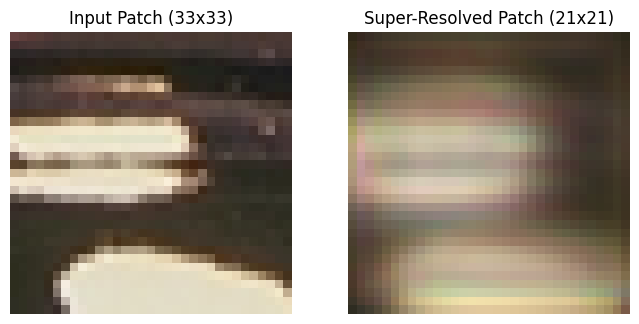

In [11]:
import torch
import matplotlib.pyplot as plt

# Load the input image
input_image_path = 'butterfly_GT.bmp'
input_image = Image.open(input_image_path).convert('RGB')

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
stride = 14
stride = 10

# Extract patches from the input image
patches = []
image_width, image_height = input_image.size

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = input_image.crop((x, y, x + input_patch_size, y + input_patch_size))
        input_patch_tensor = TF.to_tensor(input_patch)  # Convert patch to tensor (RGB format)
        patches.append(input_patch_tensor)

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches)

# Initialize and load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load('srcnn_model.pth'))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Visualize and evaluate a specific output patch
patch_index = 21  # Example patch index to visualize

# Convert output patch tensor to a PIL image
output_patch_tensor = output_batch[patch_index].detach().cpu()
output_patch_pil = TF.to_pil_image(output_patch_tensor)

# Display the input patch and the model's output (super-resolved patch)
plt.figure(figsize=(8, 4))

# Display input patch
plt.subplot(1, 2, 1)
input_patch_pil = TF.to_pil_image(input_batch[patch_index].detach().cpu())
plt.imshow(input_patch_pil)
plt.title('Input Patch (33x33)')
plt.axis('off')

# Display output patch (super-resolved)
plt.subplot(1, 2, 2)
plt.imshow(output_patch_pil)
plt.title('Super-Resolved Patch (21x21)')
plt.axis('off')

plt.show()


### Testing the images using test image

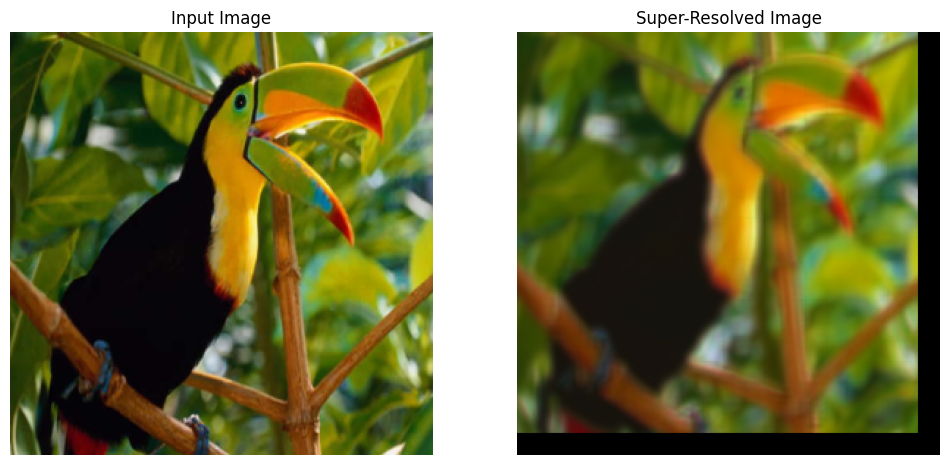

In [13]:
# Load the input image
input_image_path = "bird_GT.bmp"
input_image = Image.open(input_image_path).convert("RGB")

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
stride = 14

# Extract patches from the input image
patches = []
coords = []
image_width, image_height = input_image.size

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = input_image.crop(
            (x, y, x + input_patch_size, y + input_patch_size)
        )
        input_patch_tensor = TF.to_tensor(
            input_patch
        )  # Convert patch to tensor (RGB format)
        patches.append(input_patch_tensor)
        coords.append((x, y))

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches)

# Initialize and load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Initialize an empty tensor for the output image
output_image = torch.zeros(3, image_height, image_width)

# Place each output patch back into the correct location in the output image
# Place each output patch back into the correct location in the output image
for i, (x, y) in enumerate(coords):
    output_patch = output_batch[i]
    output_image[:, y : y + output_patch_size, x : x + output_patch_size] = (
        output_patch[
            :,
            (input_patch_size - output_patch_size)
            // 2 : (input_patch_size + output_patch_size)
            // 2,
            (input_patch_size - output_patch_size)
            // 2 : (input_patch_size + output_patch_size)
            // 2,
        ]
    )


# Convert the output image tensor to a PIL image
output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))


# Display the input image and the super-resolved image
plt.figure(figsize=(12, 6))

# Display input image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

# Display super-resolved image
plt.subplot(1, 2, 2)
plt.imshow(output_image_pil)
plt.title("Super-Resolved Image")
plt.axis("off")

plt.show()

### Calculating PSNR values for validation images

In [ ]:
# Function to calculate PSNR between two images
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if images are identical
    MAX = 255.0
    psnr = 10 * np.log10((MAX**2) / mse)
    return psnr

In [ ]:
# Initialize list to store PSNR values
psnr_values = []

# Iterate over validation loader
for inputs, labels in val_loader:
    # Move inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Generate predictions using the model
    with torch.no_grad():
        outputs = model(inputs)
        
    
    # Convert tensors to numpy arrays (RGB images)
    outputs = outputs.cpu().detach().numpy()  # Convert model outputs to numpy arrays
    print(outputs[0])
    labels = labels.cpu().detach().numpy()  # Convert labels to numpy arrays
    
    output = to_pil_image(outputs.squeeze().cpu().numpy() )
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title('Model Prediction')
    plt.axis('off')
    
    
    # Calculate PSNR for each image pair in the batch
    for i in range(outputs.shape[0]):  # Iterate over batch size
        psnr_value = calculate_psnr(outputs[i].transpose(1, 2, 0), labels[i].transpose(1, 2, 0))  # Calculate PSNR for RGB images
        psnr_values.append(psnr_value)

# Compute average PSNR over all images in the dataset
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr:.2f} dB")

### Testing the model using test images